# Исследование успешности компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные до 2016 года.

Описание данных
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


## Обзор данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# чтение файла
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score` и `Rating` есть пропущенные значения. Тип данных в столбцах `Year_of_Release` и `User_Score` необходимо изменить для удобства дальнейшей работы. Также приведем названия всех колонок к единому виду в нижнем регистре.

In [5]:
# преобразование названия колонок - все в нижнем регистре
df.columns = df.columns.str.lower()

In [6]:
df[df.year_of_release.isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [7]:
df.year_of_release.isna().sum()

269

In [8]:
df[df.name == 'Madden NFL 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Для 269 игр проущен год выпуска, однако для некоторых игр он пропущен только для какой-то платформы (выше показано на примере игры `Madden NFL 2004`). Можно предположить, что игры, которые выходили в один год на нескольких платформах, выходили в этот же год и на платформах, для которых данные пропущены. На примере `Madden NFL 2004` - год выпуска для `PS2` пропущен, но на других платформах он одинаков - `2003`, соответственно на `PS2` вероятнее всего игра также выходила в этот же год, при проверке нескольких таких вариантов в интернете это предположение подтверждается. Таким образом, заполним пропуски в годах выпуска игр для тех игр, у которых год выпуска совпадает на нескольких платформах.

In [9]:
# цикл перебирает названия игр у которых есть пропуски в годе выпуска
# если уникальное значение без учета пропуска для года выпуска у данных игр единственное, 
# то заполним пропуски этим значением
for t in df[df.year_of_release.isna()].name.unique():
    if len(df[(df.name == t) & df.year_of_release.notna()].year_of_release.unique()) == 1:
        df.loc[df.name == t, 'year_of_release'] =\
        df[(df.name == t) & df.year_of_release.notna()].year_of_release.unique()[0]

In [10]:
df.year_of_release.isna().sum()

158

Таким образом, осталось 158 пропущенных значний для года выпуска, их заполнить не предствляется возможным.

In [11]:
df[df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [12]:
((df.year_of_release.isna().sum() + df.name.isna().sum()) / len(df)) * 100

0.9572240502542626

Суммарное количество пропущенных значений года выпуска и названия игры - менее одного процента от всего датасета, поэтому для удобства можно удалить эти строки. Пропуски в `genre` совпадают с пропусками в `name`.

In [13]:
df = df[df.name.notna() & df.year_of_release.notna()] # удаляем строки с пропусками в названиях и годах выпуска
df.year_of_release = df.year_of_release.astype('int') # приводим год выпуска к целочисленным значениям

In [14]:
df.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В данных пользовательских оценок есть значения `tbd`, что означает - `To Be Determined`. Т.е. на данный момент эти значения неизвестны, таким образом можно замених их на пропущенные, чтобы в дальнейшем можно было работать с численными значениями из этого столбца. Заменять на `0` или любое другое значение нельзя, т.к. оценка может принимать эти значения на самом деле. После этого можно преобразовать тип столбца в `float`.

In [15]:
df.loc[df.user_score == 'tbd', 'user_score'] = np.nan
df.user_score = df.user_score.astype('float')

In [16]:
df.rating.sort_values().unique() # уникальные значения рейтинга

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Значение ESRB рейтинга `K-A` - `Kids to Adult` использовалось до 1998 года, далее стали использовать обозначение `E` - `Everyone`. Чтобы в данных не было этого разделения, заменим `K-A` на `E`.

In [17]:
df.loc[df.rating == 'K-A', 'rating'] = 'E'

In [18]:
df.rating.isna().sum()

6695

В значениях рейтинга 6695 пропусков, но есть игры, где пропуски в рейтинге имеются только для какой-либо платформы, т.к. игра одна и та же, то рейтинг у нее будет одинаковым вне зависимости от платформы, поэтому заполним такие пропуски где возможно. Остальные пропущенные значения заменим на `unknown`, т.к. других данных, позволяющих их заполнить, нет.

In [19]:
for t in df[df.rating.isna()].name.unique():
    if False in df[df.name == t].rating.isna().unique():
        df.loc[(df.name == t) & df.rating.isna(), 'rating'] = \
        df.loc[(df.name == t) & df.rating.notna(), 'rating'].unique()[0]

In [20]:
df.rating = df.rating.fillna('unknown')


Т.к. могут быть одни и те же игры, выпущенные на разных платформах и игры, которые перезапускались на тех же платформах в разные года, то проверим только нет ли дубликатов, когда совпадает и название, и платформа, и год выпуска игры.


In [21]:
df[['name', 'platform', 'year_of_release']].duplicated().sum()

1

In [22]:
df[df[['name', 'platform', 'year_of_release']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


In [23]:
df[(df.name == 'Madden NFL 13') & (df.platform == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E



Такая игра всего одна, причем указаны ненулевые данные по продажам только для Европы, добавим это значение к другой записи и удалим дубликат. 


In [27]:
df.loc[604, 'eu_sales'] = df.loc[604, 'eu_sales'] + df.loc[16230, 'eu_sales']
df = df.drop(16230)


Таким образом убрал еще одну строку, в выводах исправлю значение


In [24]:
# подсчет суммарных продаж во всех регионах
df['sum_sales'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16555 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16555 non-null  object 
 1   platform         16555 non-null  object 
 2   year_of_release  16555 non-null  int64  
 3   genre            16555 non-null  object 
 4   na_sales         16555 non-null  float64
 5   eu_sales         16555 non-null  float64
 6   jp_sales         16555 non-null  float64
 7   other_sales      16555 non-null  float64
 8   critic_score     8068 non-null   float64
 9   user_score       7535 non-null   float64
 10  rating           16555 non-null  object 
 11  sum_sales        16555 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


На этапе предобработки данных:

* Привели названия столбцов к единому виду в нижнем регистре
* Заполнили пропуски для года выпуска игр там, где это возможно (для игр которые одновременно выходили на нескольких платформах и известен год выпуска для нескольких платформ)
* Удалили строки с оставшимися пропусками в стобцах `name`, `genre`, `year_of_release`
* Заменили аббревиатуру `tbd` в `user_score` на пропущенное значение, т.к. на данный момент эти данные неизвестны
* Сменили тип данных на целочисленный `int` для года выпуска `year_of_release` и вещественный `float` для пользовательской оценки `user_score`
* Изменили значение рейтинга `K-A` на `E`, т.к. на данный момент используется второй вариант. Заполнили пропуски для игр, где есть данные хотя бы по одной платформе для данной игры, оставшиеся пропуски заполнили неизвестным значнением - `unknown`
* Удалили дубликаты
* Подсчитали суммарные продажи во всех регионах в новом столбце `sum_sales`

Таким образом осталось 16554 строк из 16715, убрано 0.99% от общего количества, что не повлияет на результаты дальнейшего исследования. Пропущенные значения остались в данных оценок критиков и пользователей, их не получится заменить, т.к. значения могут быть любыми из возможного диапазона, удалять эти данные также нельзя, потому что это может сильно исказить последующие выводы (более 50% пропущенных значений в обоих столбцах).

## Исследовательский анализ данных

### Количество выпускаемых игр в разные годы

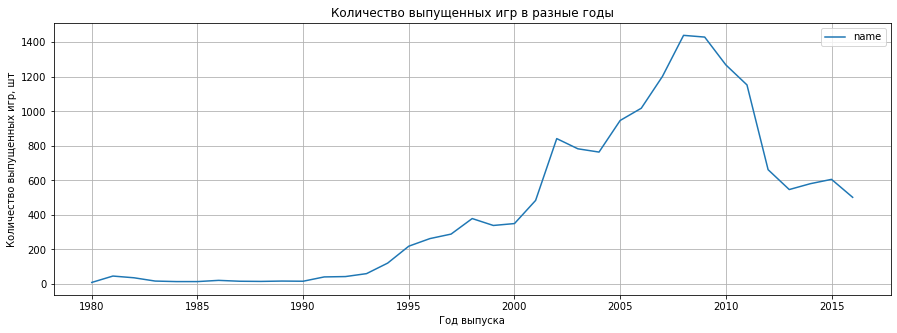

In [26]:
(
    df
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(    
        title='Количество выпущенных игр в разные годы',
        xlabel='Год выпуска',
        ylabel='Количество выпущенных игр, шт',
        grid=True,
        figsize=(15, 5)
         )
)
plt.show()

Построив зависимость количества выпущенных игр от года выпуска, можно заметить, что существенный рост выпуска игр начался со второй половины 90-х годов и продолжился до 2008 года, далее наблюдается спад, вероятно связанный с кризисом и некоторым уменьшением игрового рынка. Количество выпускаемых игр до 1995 года в каждый год значительно меньше, чем в последующие годы.

### Продажи игр для разных платформ

In [27]:
# создадим список из 5 платформ с наибольшими суммарными продажами
top_5 = (
    df
    .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
    .sort_values('sum_sales', ascending=False)
    .head()
    .reset_index()['platform']
        ).to_list()

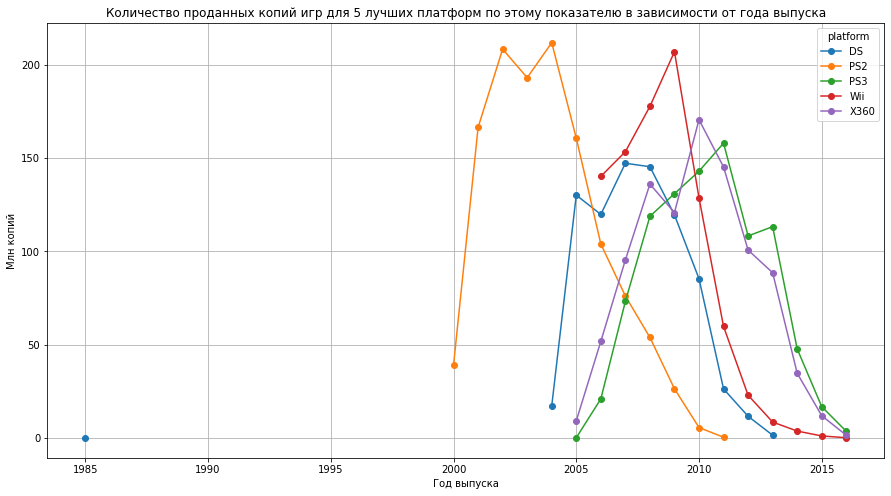

In [28]:
# график суммарных продаж для 5 лучших платформ по этому показателю
(
    df
    .query('platform in @top_5')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc='sum'
        )
    .plot(
        style='o-',
        title='Количество проданных копий игр для 5 лучших платформ по этому показателю в зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Млн копий',
        figsize=(15, 8),
        grid=True
        )
)
plt.show()

Можно заметить выбивающеся значение для платформы `DS` в 1985 году.

In [29]:
df[df.platform == 'DS'].sort_values('year_of_release').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.00,NaN,NaN,unknown,0.02
14161,Puyo Pop Fever(us sales),DS,2004,Puzzle,0.03,0.00,0.00,0.00,NaN,NaN,unknown,0.03
6578,Madden NFL 2005,DS,2004,Sports,0.24,0.00,0.00,0.02,68.0,7.7,E,0.26
6164,The Urbz: Sims In the City (US weekly sales),DS,2004,Simulation,0.26,0.00,0.00,0.02,NaN,NaN,unknown,0.28
8465,Zoo Keeper,DS,2004,Puzzle,0.10,0.01,0.05,0.01,74.0,7.5,E,0.17


`DS` - это игровая консоль `Nintendo DS`, которая была выпущена в 2004 году. Игра `Strongest Tokyo University Shogi DS` по нашим данным выпущена в 1985 году для этой консоли, такого быть не может, скорее всего это перезапуск старой игры для данной платформы, но т.к. точно установить год релиза для `Nintendo DS` не удалось, то уберем данную запись для более корректного дальнейшего анализа.

In [30]:
df = df.drop(15957)

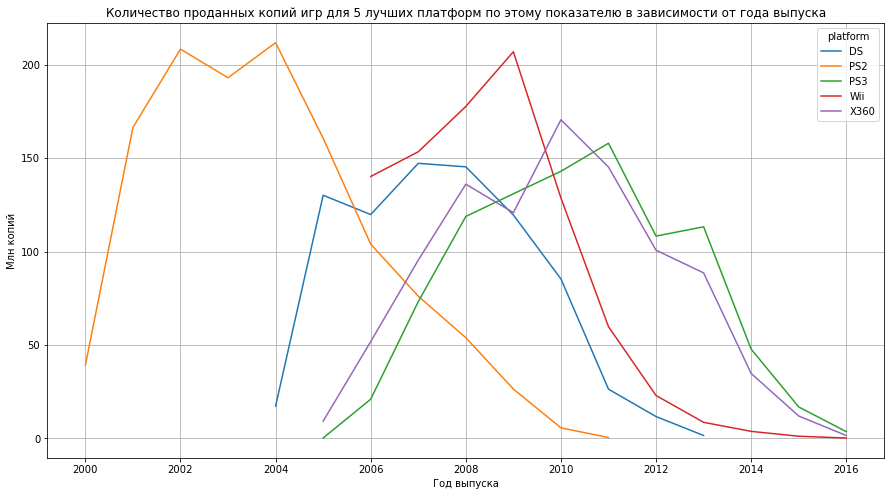

In [32]:
# график суммарных продаж для 5 лучших платформ по этому показателю
(
    df
    .query('platform in @top_5')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc='sum'
        )
    .plot(
        title='Количество проданных копий игр для 5 лучших платформ по этому показателю в зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Млн копий',
        figsize=(15, 8),
        grid=True
        )
)
plt.show()

Наибольшее количество проданных копий игр для платформ `PS2` - `Sony PlayStation 2`, `X360` - `Microsoft Xbox 360`, `PS3` - `Sony PlayStation 3`, `Wii` - `Nintendo Wii` и `DS` - `Nintendo DS`. Все графики, за исключением `Nintendo Wii`, имеют похожий вид. Начиная от выхода консоли количество проданных игр растет в течение примерно пяти лет, далее количество уменьшается, распределение похоже на нормальное. Вероятно, это связано с выходом следующих поколений игровых консолей и увеличением продаж уже для них. Для `Nintendo Wii` есть различия, в год выхода самой приставки было продано существенно большее количество игр, чем для других платформ и уже через 3 года количество стало снижаться, скорее всего это произошло в следствие мощной маркетинговой компании на страте продаж консоли и изначально более низкой стоимости, чем у конкурентов, как самой консоли, так и игр для нее.

Отдельно рассмотрим количество проданных копий игр для наиболее популярных консолей разных поколений - Sony, Microsoft и Nintendo.

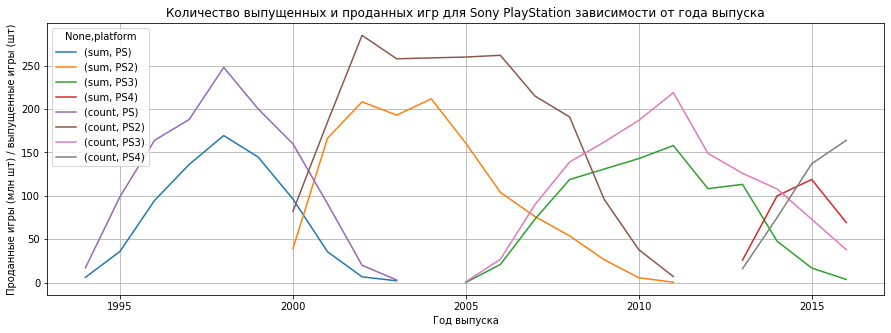

In [33]:
ps_name = ['PS', 'PS2', 'PS3', 'PS4']
    
(
    df
    .query('platform in @ps_name')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc=['sum', 'count']
        )
    .plot(
        title='Количество выпущенных и проданных игр для Sony PlayStation зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Проданные игры (млн шт) / выпущенные игры (шт)',
        figsize=(15, 5),
        grid=True
        )
)
plt.show()

Отчетливо видно, что количество игр (и выпущенных, и проданных) увеличивается с момента выхода консоли в течение примерно 5 лет и уменьшается при приближении выхода следующего поколения. За 2016 год данные неполные, поэтому нельзя говорить о спаде продаж для `PS4`.

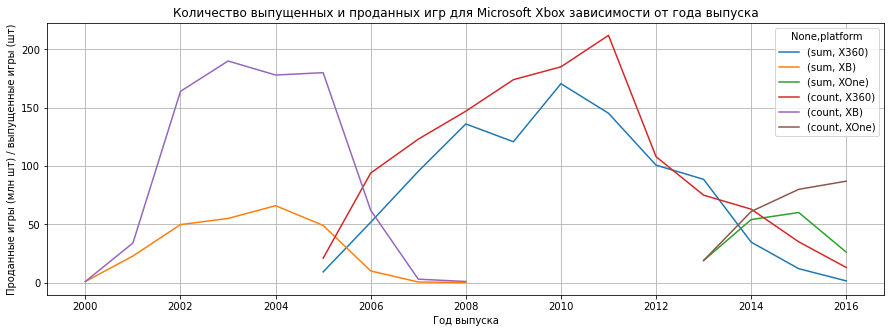

In [34]:
xb_name = ['XB', 'X360', 'XOne']

(
    df
    .query('platform in @xb_name')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc=['sum', 'count']
        )
    .plot(
        title='Количество выпущенных и проданных игр для Microsoft Xbox зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Проданные игры (млн шт) / выпущенные игры (шт)',
        figsize=(15, 5),
        grid=True
        )
)
plt.show()

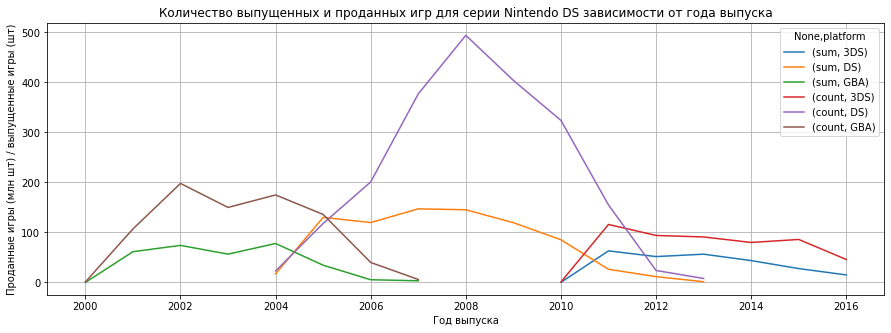

In [35]:
nintendo_name = ['GBA', 'DS', '3DS']

(
    df
    .query('platform in @nintendo_name')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc=['sum', 'count']
        )
    .plot(
        title='Количество выпущенных и проданных игр для серии Nintendo DS зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Проданные игры (млн шт) / выпущенные игры (шт)',
        figsize=(15, 5),
        grid=True
        )
)
plt.show()

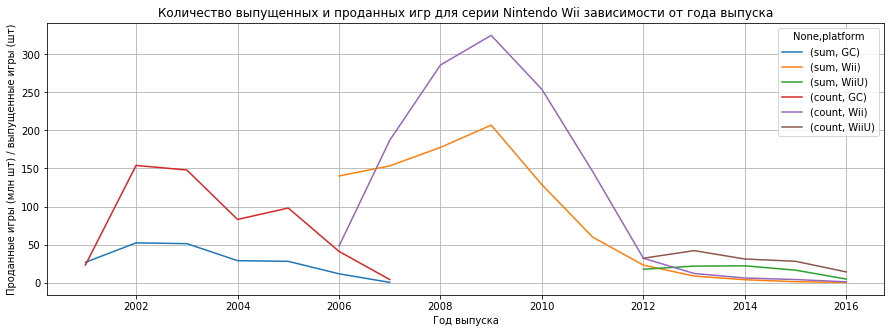

In [36]:
wii_name = ['GC', 'Wii', 'WiiU']

(
    df
    .query('platform in @wii_name')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc=['sum', 'count']
        )
    .plot(
        title='Количество выпущенных и проданных игр для серии Nintendo Wii зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Проданные игры (млн шт) / выпущенные игры (шт)',
        figsize=(15, 5),
        grid=True
        )
)
plt.show()

Для платформ `Microsoft Xbox`, `Nintendo DS` и `Nintendo Wii` графики выглядят схожим образом, что и для Sony Playstation. С выходом новых поколений приставок, продажи и выпуск игр для предыдущего поколения снижаются. Поколение консоли остается актуальным в течение 7-10 лет. Даже после выхода следующего поколения, платформы предыдущего поколения все равно остаются актуальными 2-3 года.

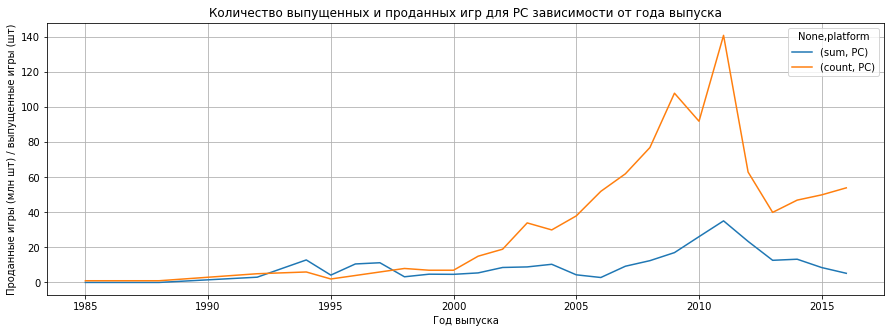

In [37]:
(
    df
    .query('platform == "PC"')
    .pivot_table(
        index='year_of_release',
        columns='platform',
        values='sum_sales',
        aggfunc=['sum', 'count']
        )
    .plot(
        title='Количество выпущенных и проданных игр для PC зависимости от года выпуска',
        xlabel='Год выпуска',
        ylabel='Проданные игры (млн шт) / выпущенные игры (шт)',
        figsize=(15, 5),
        grid=True,
        )
)
plt.show()

Отдельно стоит рассмотреть продажи и выпуск игр для компьютеров. У компьютеров нет как таковых поколений и изменения в них происходят постепенно, а игры выпускаются вне зависимости от конкретного компьютера. Заметен рост выпуска и продаж игр с 2000 до 2011 года. С 2013 года выпуск игр для `PC` вновь растет, что говорит о том, что стоит эту платформу также рассматривать как перспективную, хоть и со своими особенностями.

### Платформы за актуальный период

Чтобы определить перспективные платформы на данный момент (конец 2016 года), посмотрим на лидирующие платформы по продажам за 2015 и 2016 года.

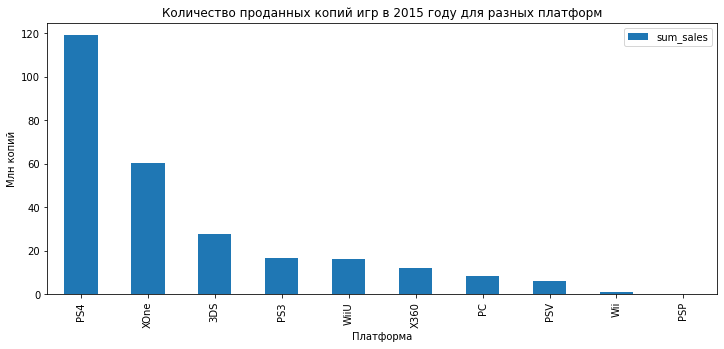

In [38]:
(
    df
    .query('year_of_release == 2015')
    .pivot_table(
        index='platform', 
        values='sum_sales', 
        aggfunc='sum'
        )
    .sort_values('sum_sales', ascending=False)
    .plot(
        kind='bar',
        title='Количество проданных копий игр в 2015 году для разных платформ',
        xlabel='Платформа',
        ylabel='Млн копий',
        figsize=(12, 5)
        )
)
plt.show()

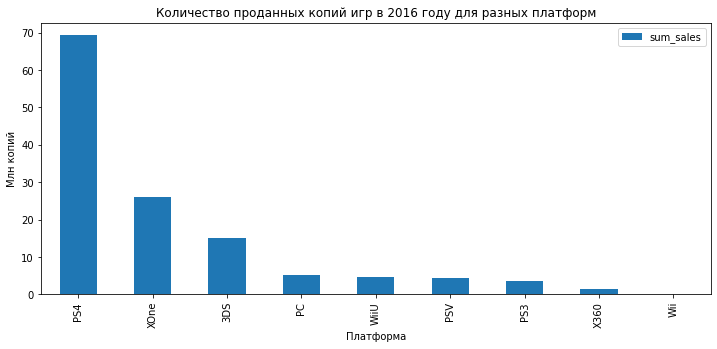

In [39]:
(
    df.query('year_of_release == 2016')
        .pivot_table(
            index='platform', 
            values='sum_sales', 
            aggfunc='sum'
            )
    .sort_values('sum_sales', ascending=False)
    .plot(
        kind='bar',
        title='Количество проданных копий игр в 2016 году для разных платформ',
        xlabel='Платформа',
        ylabel='Млн копий',
        figsize=(12, 5)
        )
)
plt.show()

Лидирующие платформы и в 2015 и в 2016 неизменны - `PS4`, `XOne`, `3DS`. В "пятерке" наиболее популярных платформ в 2015 году находится и `PS3`, но уже в 2016 ее место занимает `PC`. `PS3` была выпущена в 2005 году, поэтому как раз к 2016 году спустя 10 лет она теряет свою актуальность, ей на смену в 2013 году пришла `PS4`. Приставка `WiiU` выпущена в 2012 году и продажи игр для нее к 2016 году должны расти, однако мы видим спад и в целом показатели для нее сильно хуже, чем для предыдущего поколения - `Wii`, можно говорить, что `WiiU` не стала такой популярной и уже спустя 3 года после релиза продажи игр падают. Таким образом, рассмотрим более подробно 5 лидирующих платформ в 2016 году, ориентироваться будем на период с 2013 года до 2016.

In [40]:
# создадим список из 5 лучших платформ по продажам игр за 2016 год
best_in_2016 = (
    df.query('year_of_release == 2016')
        .pivot_table(index='platform', values='sum_sales', aggfunc='sum')
        .sort_values('sum_sales', ascending=False)
        .head()
        .reset_index()['platform']
        .to_list()
    )

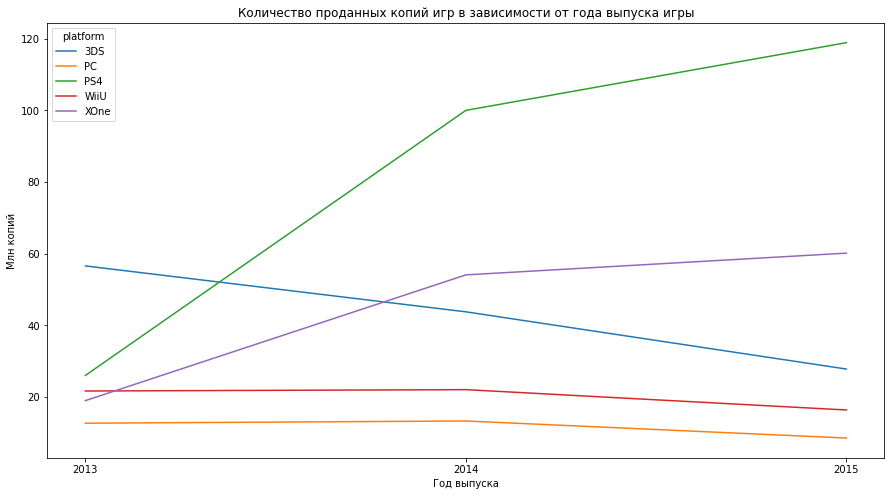

In [98]:
(
    df.query('platform in @best_in_2016 and 2012 < year_of_release < 2016')
        .pivot_table(
            index='year_of_release', 
            columns='platform', 
            values='sum_sales',
            aggfunc='sum'
            )
        .plot(
             
            figsize=(15, 8),
            title='Количество проданных копий игр в зависимости от года выпуска игры',
            xlabel='Год выпуска',
            ylabel='Млн копий'
            )
)
plt.xticks(np.arange(2013, 2016, 1))
plt.show()

Чтобы посмотреть на тенденции к росту или падению рассматриваем данные о продажах без учета 2016 года, т.к. в этом году они неполные. Рост количества проданных игр показывают только две платформы - `Sony PlayStation 4` и `Xbox One`. Эти консоли вышли в 2013 году и предположительно до 2018 года продажи игр для них будут расти, если ориентироваться на данные для прошлых поколений этих приставок. Остальные платформы выпущены раньше и к 2015 году уже наблюдается тенденция на спад продаж игр для них. Для `PC` также наблюдается некоторый спад, однако из предыдущего стобчатого графика видно, что уже в 2016 с учетом неполноты данных количество проданных игр для `PC` будет уже больше, чем для `WiiU` и т.к. это компьютеры, то игры будут продолжать выпускаться (не будет падения до 0 как для консолей).

### Глобальные продажи в разбивке по платформам

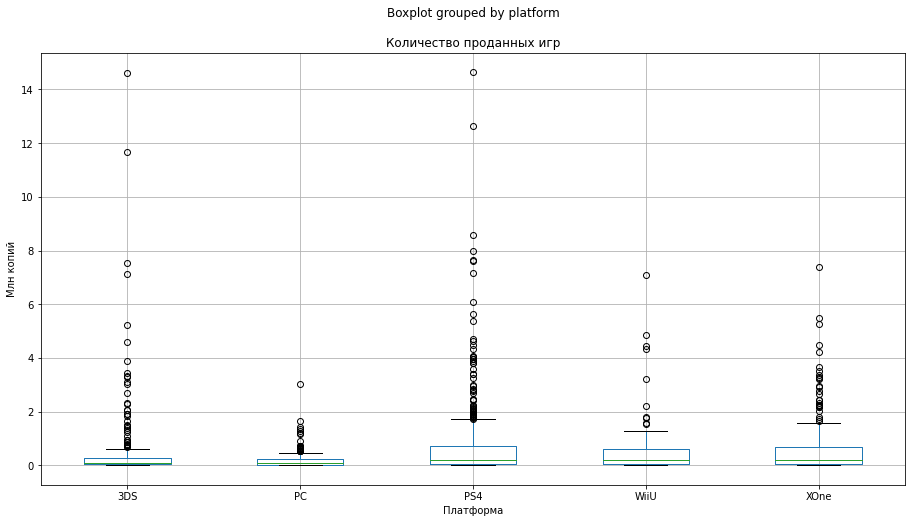

In [41]:
df.query('platform in @best_in_2016 and year_of_release > 2012').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8)
)

plt.title('Количество проданных игр')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()

У некоторых платформ есть большие выбросы, уменьшим диапазон, чтобы было нагляднее.

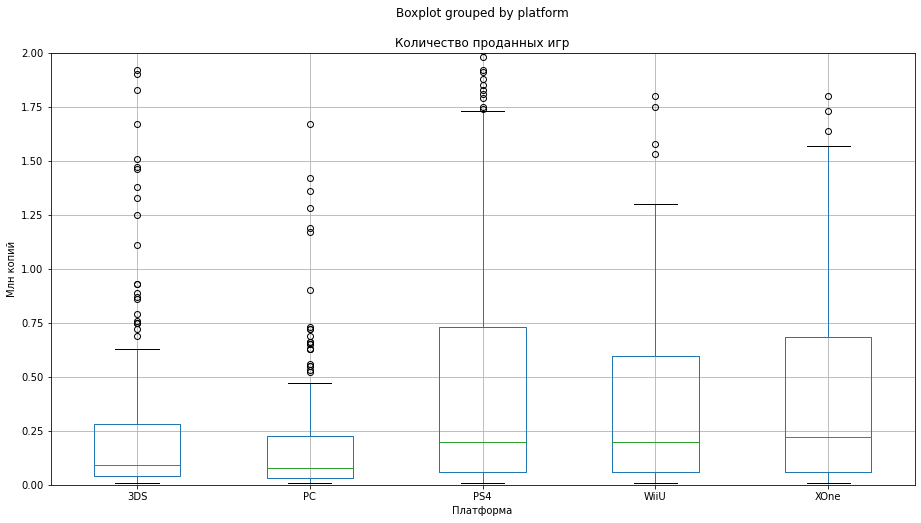

In [42]:
df.query('platform in @best_in_2016 and year_of_release > 2012').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8)
)
plt.ylim(0, 2)
plt.title('Количество проданных игр')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()

In [43]:
df.query('platform in @best_in_2016 and year_of_release > 2012').groupby('platform').sum_sales.describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.04,0.09,0.280,14.60
PC,191.0,0.207906,0.350569,0.01,0.03,0.08,0.225,3.05
PS4,392.0,0.801378,1.609456,0.01,0.06,0.20,0.730,14.63
WiiU,115.0,0.562000,1.038778,0.01,0.06,0.20,0.595,7.09
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.685,7.39


Среди данных платформ лидируют по продажам - `PS4`, `XOne`, `WiiU`. Это самые новые платформы из представленных. `3DS` хоть и уступает, но имеет довольно большое количество выбросов с хорошими продажами и несколько сверхуспешных игр также продавались для `3DS`, рассмотрим и эту приставку тоже. Также оставим и `PC`, т.к. она отличается от остальных и имеет довольно много выбросов с успешными продажами. Хотя наиболее перспективными, как мы рассматривали выше, остаются `PS4` и `XOne` - только они показывают рост в продажах игр.

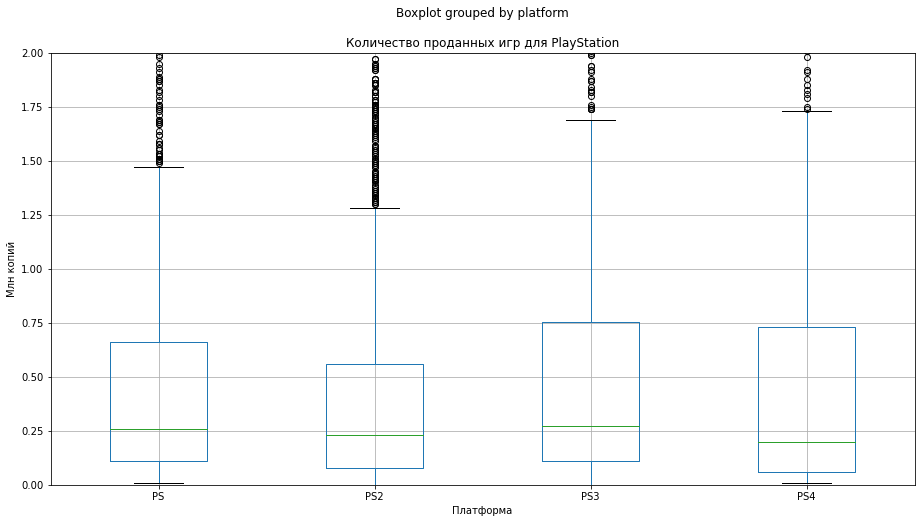

In [44]:
df.query('platform in @ps_name').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8)
)
plt.ylim(0, 2)
plt.title('Количество проданных игр для PlayStation')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()

Медианные значения продаж для всех поколений `PlayStation` примерно одинаковы, для `PS4` несколько ниже, т.к. на текущий момент данные неполные - игры в продаже всего 3 года. 

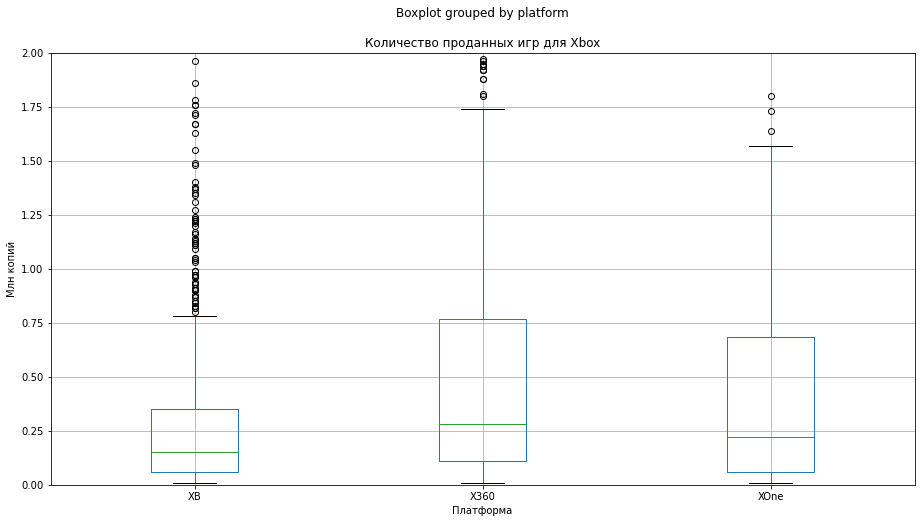

In [45]:
df.query('platform in @xb_name').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8),
    positions=[1, 0, 2]
)

plt.ylim(0, 2)
plt.title('Количество проданных игр для Xbox')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()


`Xbox 360` наиболее успешная версия среди консолей от Microsoft, также это объясняется и тем, что она была "актуальна" более продолжительный период времени. `Xbox` выпускался в течение 8 лет, а `Xbox 360` в течение 11. Для `Xbox One` на текущий момент данные еще неполные, она в продаже всего 3 года.

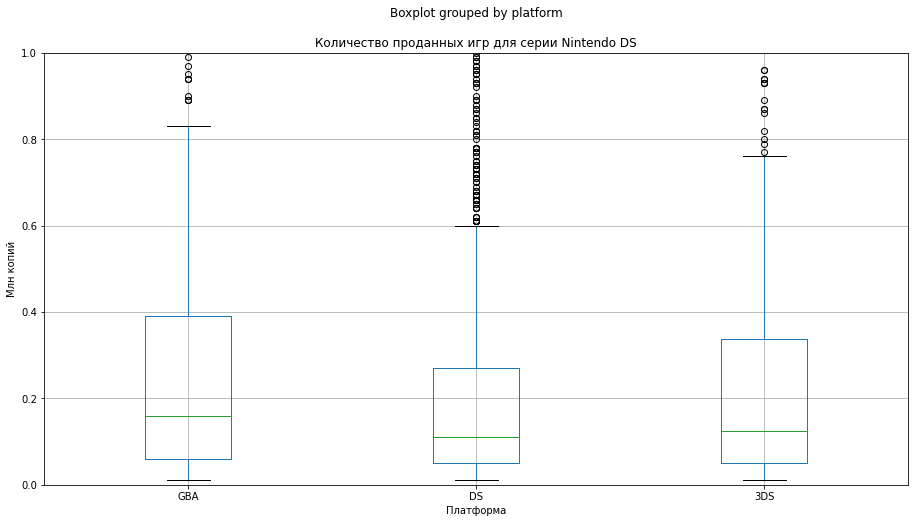

In [46]:

df.query('platform in @nintendo_name').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8),
    positions=[2, 1, 0]
)

plt.ylim(0, 1)
plt.title('Количество проданных игр для серии Nintendo DS')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()

В целом данные приставки от `Nintendo` одинаково успешны, хотя для `Nintendo DS` есть большое количество выбросов - сверхуспешных игр по продажам.

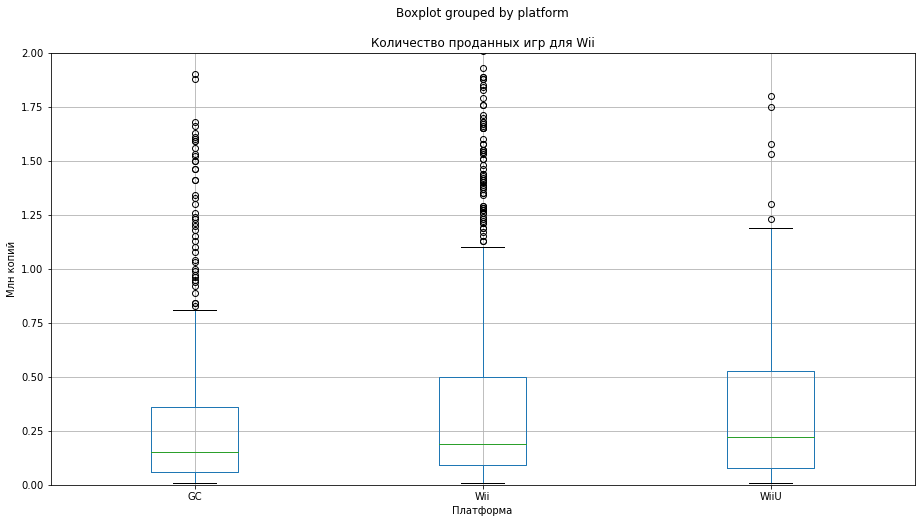

In [47]:

df.query('platform in @wii_name').boxplot(
    by='platform', 
    column='sum_sales', 
    figsize=(15, 8),
)

plt.ylim(0, 2)
plt.title('Количество проданных игр для Wii')
plt.xlabel('Платформа')
plt.ylabel('Млн копий')
plt.show()

Не смотря на то, что медианные продажи для `WiiU` выше, для этой приставки не так много выбросов - наиболее успешных игр по продажам.

### Зависимость количества проданных игр от оценок пользователей и критиков

In [48]:
# коэффициенты корреляции между отзывами пользователей, критиков и глобальными продажами
# для 5 лучших платформ по продажам за все время
df.query('platform in @top_5').groupby('platform')[['user_score', 'critic_score', 'sum_sales']].corr()

user_score  critic_score  sum_sales
platform                                                  
DS       user_score      1.000000      0.654032   0.130456
         critic_score    0.654032      1.000000   0.236311
         sum_sales       0.130456      0.236311   1.000000
PS2      user_score      1.000000      0.562711   0.173715
         critic_score    0.562711      1.000000   0.395675
         sum_sales       0.173715      0.395675   1.000000
PS3      user_score      1.000000      0.627007   0.127447
         critic_score    0.627007      1.000000   0.432595
         sum_sales       0.127447      0.432595   1.000000
Wii      user_score      1.000000      0.682232   0.113467
         critic_score    0.682232      1.000000   0.177903
         sum_sales       0.113467      0.177903   1.000000
X360     user_score      1.000000      0.623261   0.113650
         critic_score    0.623261      1.000000   0.391742
         sum_sales       0.113650      0.391742   1.000000

In [49]:
# коэффициенты корреляции между отзывами пользователей, критиков и глобальными продажами
# для лучших актуальных платформ по продажам с 2013 года
df.query('platform in @best_in_2016 and year_of_release > 2012').groupby('platform')\
[['user_score', 'critic_score', 'sum_sales']].corr()

user_score  critic_score  sum_sales
platform                                                  
3DS      user_score      1.000000      0.769536   0.241504
         critic_score    0.769536      1.000000   0.357057
         sum_sales       0.241504      0.357057   1.000000
PC       user_score      1.000000      0.427990  -0.093314
         critic_score    0.427990      1.000000   0.198288
         sum_sales      -0.093314      0.198288   1.000000
PS4      user_score      1.000000      0.557654  -0.031957
         critic_score    0.557654      1.000000   0.406568
         sum_sales      -0.031957      0.406568   1.000000
WiiU     user_score      1.000000      0.721313   0.419330
         critic_score    0.721313      1.000000   0.376415
         sum_sales       0.419330      0.376415   1.000000
XOne     user_score      1.000000      0.472462  -0.068925
         critic_score    0.472462      1.000000   0.416998
         sum_sales      -0.068925      0.416998   1.000000

Ни для одной из платформ не наблюдается прямой зависимости количества проданных игр от пользовательской оценки или оценки критиков. Коэффициент корреляции не превышает 0.43.

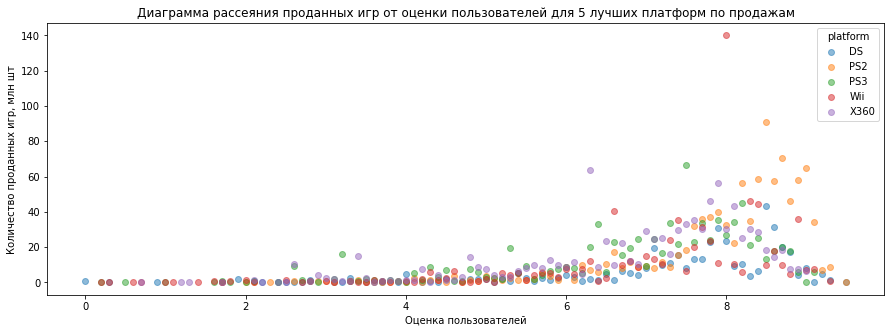

In [50]:
(
    df
    .query('platform in @top_5')
    .pivot_table(index='user_score', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(
        style='o',
        alpha=0.5,
        figsize=(15, 5),
        title='Диаграмма рассеяния проданных игр от оценки пользователей для 5 лучших платформ по продажам',
        xlabel='Оценка пользователей',
        ylabel='Количество проданных игр, млн шт'
        )
)
plt.show()

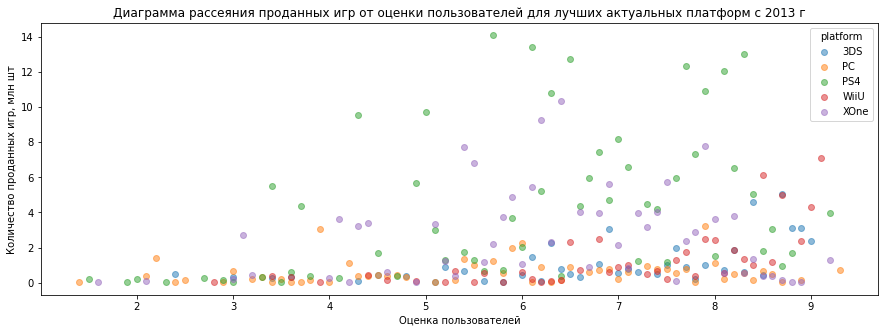

In [51]:
(
    df
    .query('platform in @best_in_2016 and year_of_release > 2012')
    .pivot_table(index='user_score', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(
        style='o', 
        alpha=0.5,
        figsize=(15, 5),
        title='Диаграмма рассеяния проданных игр от оценки пользователей для лучших актуальных платформ c 2013 г',
        xlabel='Оценка пользователей',
        ylabel='Количество проданных игр, млн шт'
        )
)
plt.show()

Из диаграм рассеяния наглядно видно, что прямой зависимости количества проданных игр от оценки пользователей нет, особенно это заметно для актуальных платформ с 2013 года. Можно лишь сказать, что в целом при оценке выше 6 количество проданных игр больше.

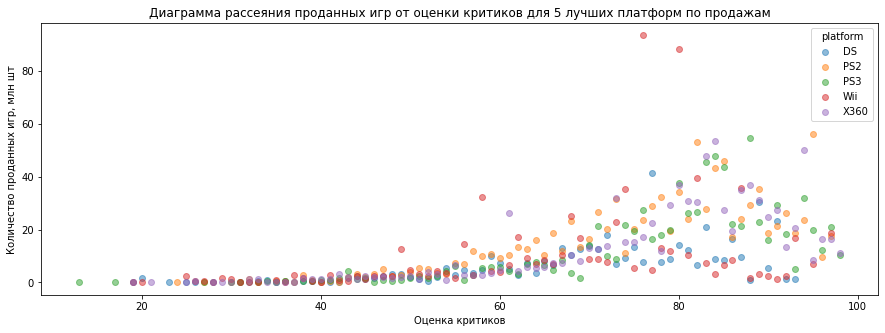

In [52]:
(
    df
    .query('platform in @top_5')
    .pivot_table(index='critic_score', columns='platform', values='sum_sales', aggfunc='sum')
    .plot(
        style='o', 
        alpha=0.5,
        figsize=(15, 5),
        title='Диаграмма рассеяния проданных игр от оценки критиков для 5 лучших платформ по продажам',
        xlabel='Оценка критиков',
        ylabel='Количество проданных игр, млн шт'
        )
)
plt.show()

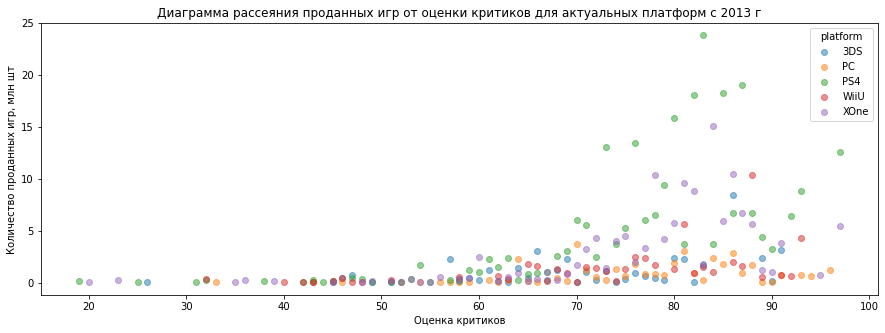

In [53]:
(
    df
    .query('platform in @best_in_2016 and year_of_release > 2012')
    .pivot_table(index='critic_score', columns='platform',values='sum_sales', aggfunc='sum')
    .plot(
        style='o', 
        alpha=0.5,
        figsize=(15, 5),
        title='Диаграмма рассеяния проданных игр от оценки критиков для актуальных платформ c 2013 г',
        xlabel='Оценка критиков',
        ylabel='Количество проданных игр, млн шт'
        )
)
plt.show()

От оценки критиков также не наблюдается прямой зависимости. При оценках выше 70 количество проданных игр возрастает. Это справедливо для любой платформы.

### Распределение игр по жанрам

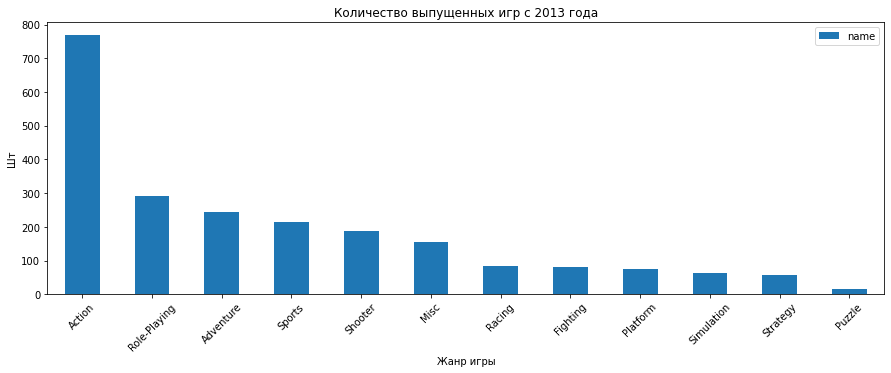

In [54]:
(
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='name', aggfunc='count')
    .sort_values('name', ascending=False)
    .plot(
        kind='bar',
        figsize=(15, 5),
        title='Количество выпущенных игр с 2013 года',
        xlabel='Жанр игры',
        ylabel='Шт',
        rot=45
    )
)
plt.show()

С 2013 года было выпущено больше всего игр жанра `Action`, причем более чем в 2.5 раза больше, чем игр второго жанра по популярности - `Role-Playing`.

In [55]:
(
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='sum_sales', aggfunc='sum')
    .sort_values('sum_sales', ascending=False)
)

,sum_sales
genre,
Action,322.15
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,63.06
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


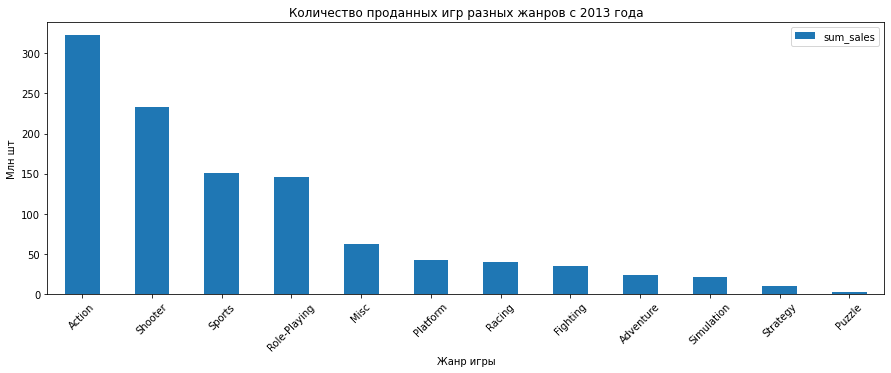

In [56]:
(
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='sum_sales', aggfunc='sum')
    .sort_values('sum_sales', ascending=False)
    .plot(
        title='Количество проданных игр разных жанров c 2013 года',
        xlabel='Жанр игры',
        ylabel='Млн шт',
        kind='bar',
        figsize=(15, 5),
        rot=45
        )
)

plt.show()

Наиболее прибыльный жанр игр - `Action`. Игр этого жанра продано примерно в 100 раз больше, чем наименее популярного - `Puzzle`. Хорошие показатели (более 145 млн проданных копий игр с 2013 года ) показывают 4 жанра - `Action`, `Shooter`, `Sports`, `Role-Playing`.

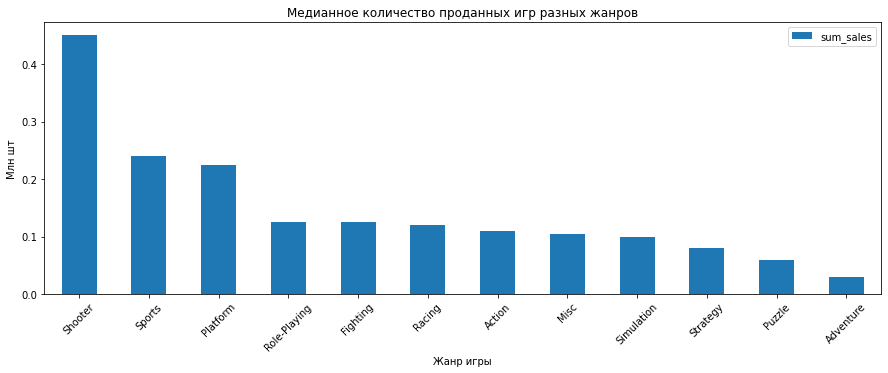

In [57]:
(
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='sum_sales', aggfunc='median')
    .sort_values('sum_sales', ascending=False)
    .plot(
        title='Медианное количество проданных игр разных жанров',
        xlabel='Жанр игры',
        ylabel='Млн шт',
        kind='bar',
        figsize=(15, 5),
        rot=45
        )
)
plt.show()

In [58]:
df.query('year_of_release > 2012').sort_values('sum_sales', ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


Однако, если предположить, что есть какие-то конкретные игры, которые продаются значительно лучше или хуже остальных и посмотреть на медиану продаж, чтобы исключить эти влияния, то картина несколько меняется. Таким образом, в среднем лучше продаются игры жанра `Shooter`, в тройку лидеров попадает жанр `Platform`. А жанр `Action`, лидирующий по общим продажам, становится только 7-м при сравнении медианных продаж. Это связано с тем, что есть сверхуспешная игра жанра `Action` - `Grand Theft Auto V`, ее продажи сильно увеличивают общие показатели для этого жанра, а общее количество игр данного жанра также велико, что говорит о том, что большое количество игр `Action` не являются популярными.

## Портрет пользователя каждого региона

### Популярные платформы

In [59]:
# 5 наиболее прибыльных платформ в Северной Америке c 2013 года
na_top_5 = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values('na_sales', ascending=False)
    .head()
)
regions_top = na_top_5 #создадим также дополнительный датафрейм со всеми популярными платформами по регионам
na_top_5

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


In [60]:
# 5 наиболее прибыльных платформ в Европе с 2013 года
eu_top_5 = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values('eu_sales', ascending=False)
    .head()
)
regions_top = regions_top.merge(eu_top_5, how='outer', on='platform') # добавим данные для Европы
eu_top_5

,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


In [61]:
# 5 наиболее прибыльных платформ в Японии с 2013 года
jp_top_5 = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values('jp_sales', ascending=False)
    .head()
)
regions_top = regions_top.merge(jp_top_5, how='outer', on='platform') # добавим данные для Японии
jp_top_5

,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


In [62]:
regions_top

,na_sales,eu_sales,jp_sales
platform,,,
PS4,108.74,141.09,15.96
XOne,93.12,51.59,NaN
X360,81.66,42.52,NaN
PS3,63.50,67.81,23.35
3DS,38.20,30.96,67.81
PSV,NaN,NaN,18.59
WiiU,NaN,NaN,10.88


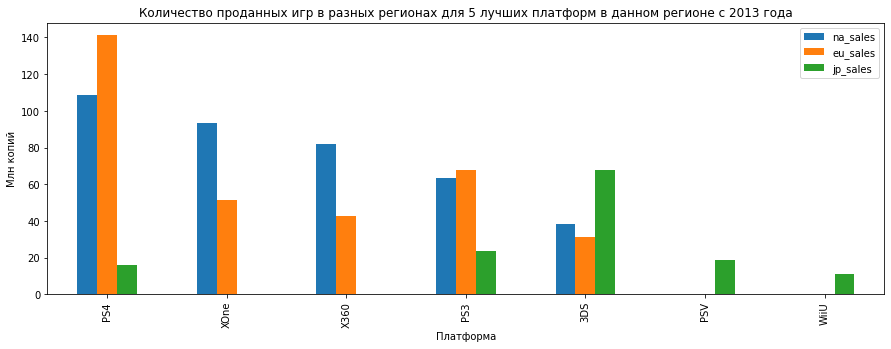

In [63]:
regions_top.plot(
    kind='bar', 
    figsize=(15, 5),
    title='Количество проданных игр в разных регионах для 5 лучших платформ в данном регионе с 2013 года',
    xlabel='Платформа',
    ylabel='Млн копий'
    )
plt.show()

* В **Северной Америке** и **Европе** наиболее популярны одни и те же платформы - `PlayStation 3 и 4`, `Xbox 360 и One`, `Nintendo 3DS`. Лидирует в обоих регионах `PlayStation 4`.
* В **Европе** приставки от `Sony` - `PS3` и `PS4` заметно успешнее своих прямых конкурентов от `Microsoft` - `X360` и `XOne`.
* В **Северной Америке** `Xbox 360` опережает своего конкурента `PlayStation 3` по продажам игры, а `Xbox One` хоть и уступает `PlayStation 4`, но не так значительно как в **Европе**.
* Игровой рынок **Японии** сильно отличается от североамериканского и европейского. Лидирует по общему количеству проданных игр `Nintendo 3DS`, тогда как в других регионах она лишь пятая. Также в пятерку лучших входят `PlayStation Vita` и `Nintendo Wii U`, которых нет среди наиболее успешных в других регионах. Японские пользователи предпочитают консоли своего производства, приставок от `Microsoft` нет среди популярных в этой стране.

### Популярные жанры

In [64]:
# 5 наиболее прибыльных жанров в Северной Америке c 2013 года
na_top_5_genres = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values('na_sales', ascending=False)
    .head()
)
#создадим также дополнительный датафрейм со всеми популярными жанрами по регионам
regions_top_genres = na_top_5_genres 
na_top_5_genres

,na_sales
genre,
Action,126.07
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


In [65]:
# 5 наиболее прибыльных жанров в Европе с 2013 года
eu_top_5_genres = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values('eu_sales', ascending=False)
    .head()
)
# добавим данные для Европы
regions_top_genres = regions_top_genres.merge(eu_top_5_genres, how='outer', on='genre')
eu_top_5_genres

,eu_sales
genre,
Action,118.36
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


In [66]:
# 5 наиболее прибыльных жанров в Японии с 2013 года
jp_top_5_genres = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values('jp_sales', ascending=False)
    .head()
)
# добавим данные для Японии
regions_top_genres = regions_top_genres.merge(jp_top_5_genres, how='outer', on='genre')
jp_top_5_genres

,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.44
Fighting,7.65
Shooter,6.61


In [67]:
regions_top_genres

,na_sales,eu_sales,jp_sales
genre,,,
Action,126.07,118.36,40.49
Shooter,109.74,87.86,6.61
Sports,65.27,60.52,NaN
Role-Playing,46.40,36.97,51.04
Misc,27.49,NaN,9.44
Racing,NaN,20.19,NaN
Fighting,NaN,NaN,7.65


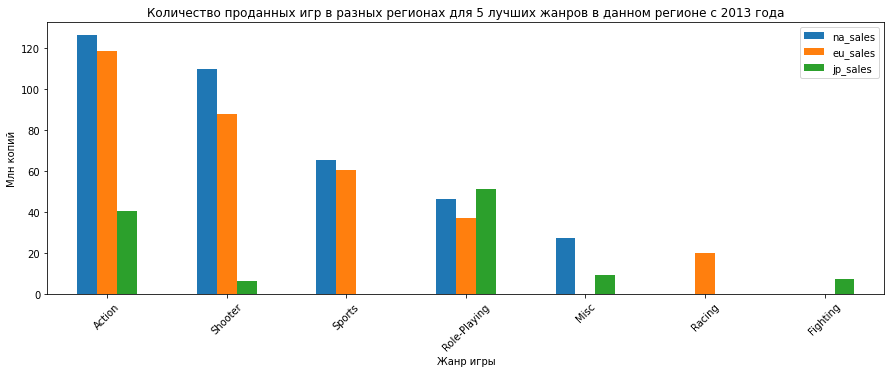

In [68]:
regions_top_genres.plot(
    kind='bar', 
    figsize=(15, 5),
    title='Количество проданных игр в разных регионах для 5 лучших жанров в данном регионе с 2013 года',
    xlabel='Жанр игры',
    ylabel='Млн копий',
    rot=45
    )
plt.show()

**Японский** рынок при рассмотрении жанров игр также отличается от остальных. В **Японии** лидируют по продажам ролевые компьютерные игры `Role-Playing`, также в пятерку входит жанр `Fighing`, которого нет среди топ 5 популярных жанров в других регионах. В **Северной Америке** и **Европе** наиболее популярны жанры `Action`, `Shooter` и `Sports`. Жанр `Racing` входит в топ 5 только в **Европе**.

Однако чтобы не учитывать влияние сильно успешных или провальных игр и посмотреть стабильно прибыльные жанры, рассмотрим медиану продаж для каждого региона.

In [69]:
# 5 наиболее прибыльных жанров в других странах с 2013 года
other_top_5_genres = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='other_sales', aggfunc='sum')
    .sort_values('other_sales', ascending=False)
    .head()
)
# добавим данные для других стран
regions_top_genres = regions_top_genres.merge(other_top_5_genres, how='outer', on='genre')
other_top_5_genres

,other_sales
genre,
Action,37.23
Shooter,28.77
Sports,19.45
Role-Playing,11.48
Misc,6.09


In [70]:
region_top_genres_median = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='genre', values='na_sales', aggfunc='median')
    .sort_values('na_sales', ascending=False).head()
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='genre', values='eu_sales', aggfunc='median')
        .sort_values('eu_sales', ascending=False).head(), 
        how='outer', on='genre'
    )
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='genre', values='jp_sales', aggfunc='median')
        .sort_values('jp_sales', ascending=False).head(), 
        how='outer', on='genre'
    )
)
region_top_genres_median

,na_sales,eu_sales,jp_sales
genre,,,
Shooter,0.200,0.190,NaN
Platform,0.090,0.080,NaN
Sports,0.080,0.050,NaN
Fighting,0.045,NaN,0.03
Racing,0.030,0.060,NaN
Simulation,NaN,0.035,NaN
Role-Playing,NaN,NaN,0.05
Misc,NaN,NaN,0.02
Puzzle,NaN,NaN,0.02


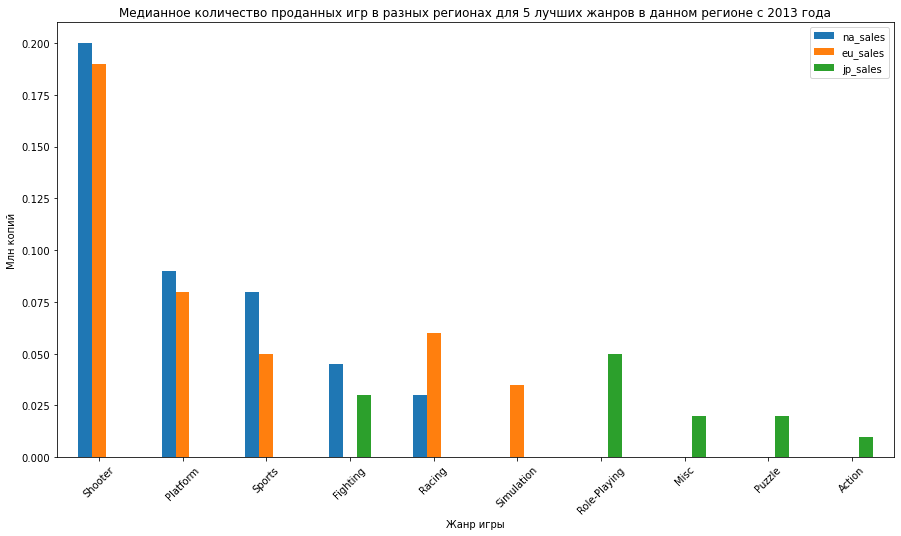

In [71]:
region_top_genres_median.plot(
    kind='bar', 
    figsize=(15, 8),
    title='Медианное количество проданных игр в разных регионах для 5 лучших жанров в данном регионе с 2013 года',
    xlabel='Жанр игры',
    ylabel='Млн копий',
    rot=45
    )
plt.show()

* В целом игровые рынки **Северной Америки** и **Европы** похожи. В этих регионах лидируют игры жанра `Shooter` и `Platform`, причем продажи жанра `Shooter` в два раза выше следующиего за ним жанра `Platform`. Также во всех этих регионах популярен жанр `Sports`. В **Европе** среди лучших пристутсвует жанр `Simulation` (и только в Европе среди трех представленных регионов), а в **Северной Америке** жанр `Fighting`.
* **Японский** рынок вновь отличается. Наиболее популярный жанр игр в этой стране - `Role-Playing`, причем в остальных регионах этот жанр даже не присутствует в топ 5. Еще три жанра (`Misc`, `Puzzle` и `Action`), популярных в **Японии**, также не входят в пятерку лучших в **Северной Америке** и **Европе**, а лидирующие там жанры `Shooter`, `Platform` и `Sports` не входят в пятерку в **Японии**.

### Зависимость продаж от рейтинга ESRB

In [72]:
region_rating = (
    df
    .query('year_of_release > 2012')
    .pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='rating', values='eu_sales', aggfunc='sum'), how='outer', on='rating'
    )
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='rating', values='jp_sales', aggfunc='sum'), how='outer', on='rating'
    )
)
region_rating

,na_sales,eu_sales,jp_sales
rating,,,
E,81.71,85.49,15.98
E10+,56.38,45.20,6.27
M,172.84,153.94,14.96
T,51.98,43.68,22.84
unknown,74.82,64.15,80.97


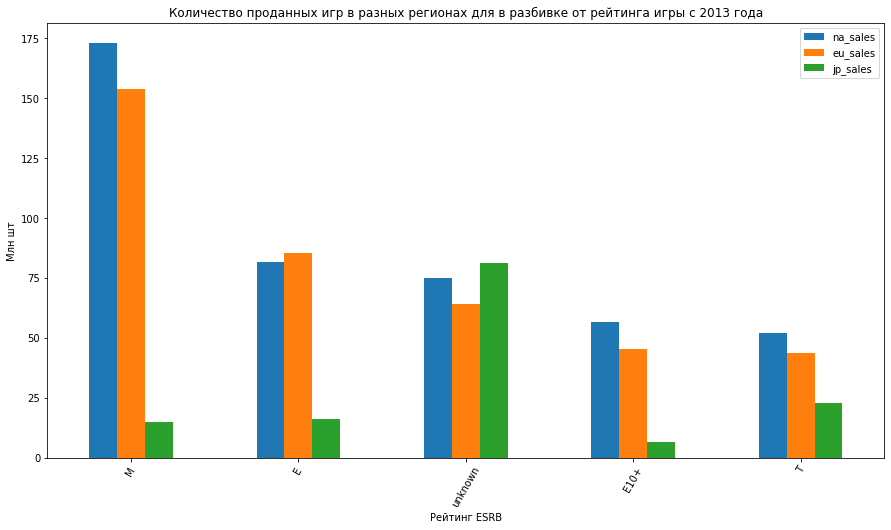

In [73]:
region_rating.sort_values('na_sales', ascending=False).plot(
    kind='bar',
    title='Количество проданных игр в разных регионах для в разбивке от рейтинга игры с 2013 года',
    xlabel='Рейтинг ESRB',
    ylabel='Млн шт',
    figsize=(15, 8),
    rot=60
)
plt.show()

И в **Северной Америке**, и в **Европе** больше всего продано копий игр с рейтингом `M` - `Mature`, вероятно, это также связно с большими продажами игр жанра `Action`, которые имеют данный рейтинг. Заметно также отличие японского рынка, рассмотрим более подробно без учета сверхприбыльных игр.

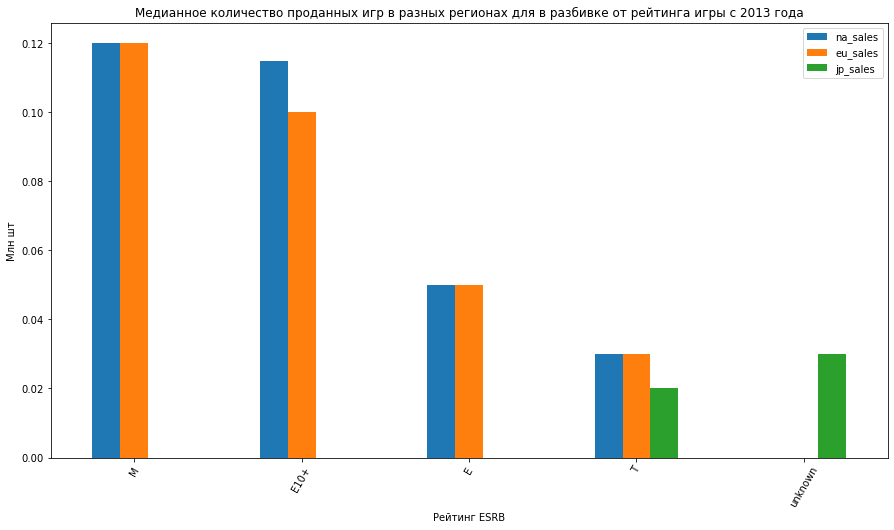

In [74]:
(
    df
    .query('year_of_release > 2012')
    .pivot_table(index='rating', values='na_sales', aggfunc='median')
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='rating', values='eu_sales', aggfunc='median'), how='outer', on='rating'
    )
    .merge(
        df
        .query('year_of_release > 2012')
        .pivot_table(index='rating', values='jp_sales', aggfunc='median'), how='outer', on='rating'
    )
).sort_values('na_sales', ascending=False).plot(
    kind='bar',
    title='Медианное количество проданных игр в разных регионах для в разбивке от рейтинга игры с 2013 года',
    xlabel='Рейтинг ESRB',
    ylabel='Млн шт',
    figsize=(15, 8),
    rot=60
)
plt.show()

При рассмотре медианных в **Северной Америке** и **Европе** значений также больше все продано игр с рейтингом `M` - в данном случае этот рейтинг соответствует играм жанра `Shooting`, наиболее стабильно популярного в этих регионах. Рейтинги `E10+` - `Everyone 10 and older` и `E` - `Everyone` присваиваются играм многих жанров, поэтому игры данных рейтингов также составляют большую долю продаж в этих регионах.

В **Японии** большинство проданных игр не имеют рейтинга, это объясняется тем, что рейтинг ESRB предназначен для США и Канады. В **Европе** играют в те же игры, что и в **Северной Америке**, поэтому и рейтинги совпадают, а в **Японии** популярны другие жанры, для которых уже рейтинг ESRB не присвоен, т.к. эти игры вероятно выпускаются специально для японского рынка.

**Портрет пользователя каждого региона**
* Пользователи из **Северной Америки** с 2013 года предпочитают играть на `PlayStation 4`, `Xbox One`, `Xbox 360` и `PlayStation 3`. Платформа `Xbox 360` превосходит своего конкурента от `Sony`, а `Xbox One` уступает конкуренту `PlayStation 4` всего на 15% проданных копий игр. Стабильно популярные жанры игр в этом регионе - `Shooter`, `Platform`, `Sports`, `Fightning` и `Racing`, хотя наибольшее количество копий продано игр жанра `Action` - благодаря сверхуспешной игре `Grand Theft Auto V`. Чаще покупают игры с рейтингами ESRB `M`, `E10+` и `E`, которые и соответствуют более успешным жанрам игр.
* В **Европе** в основном покупают игры для `Sony PlayStation 3 и 4`, эти платформы опережают своих прямых конкурентов от `Microsoft`, причем `PS3` имеет показатели даже лучше, чем у более современной консоли `Xbox One`. Для `PS4` в **Европе** продано на 64% больше игр, чем для `Xbox One`, а для `PS3` на 37% больше, чем для `Xbox 360`. Европейские пользователи предпочитают играть в игры жанров `Shooter` и `Platform`, так же, как и в Северной Америке. Также популярен жанр `Sports`, а игры жанра `Racing` третьи по успешности. В пятерку лучших входит жанр `Simulation`, игры этого жанра пользуются таким успехом только среди европейских пользователей. Рейтинги ESRB так же соответствуют популярным жанрам и практически полностью идентичны североамериканским - среди лучших по продажам `M`, `E10+` и `E`.
* Предпочтения пользователей из **Японии** значительно отличаются от европейских и североамериканских. Наиболее успешная по количеству проданных игр платформа в **Японии** - `Nintendo 3DS`. Среди популярных приставок нет приставок от `Microsoft`, которые есть в других регионах. Наиболее успешный жанр как по общим продажам, так и по медианным продажам - `Role-Playing`. Жанры `Misc`, `Puzzle` и `Action` стабильно популярны только в Японии, а популярные среди североамериканцев и европейцев жанры `Shooter`, `Platform` и `Sports` не входят в пятерку лучших у японских пользователей. Т.к. предпочтения в игровых жанрах так отличаются, а игры выпускающиеся для японского рынка не имеют рейтинга ESRB, то сказать что-то о распределении продаж в зависимости от рейтинга невозможно.

## Проверка гипотез

In [75]:
# создадим датафрейм без пропущенных значений
user_score_df = df.query('year_of_release > 2012')[['platform', 'genre', 'user_score']].dropna()

**Проверка гипотезы: Средние пользовательские рейтинги платформ `Xbox One` и `PC` одинаковые**

```
H_0: Оценка (user_score) пользователей Xbox One = оценка (user_score) пользователей PC
H_a: Оценка (user_score) пользователей Xbox One ≠ оценка (user_score) пользователей PC
alpha = 0.05
```

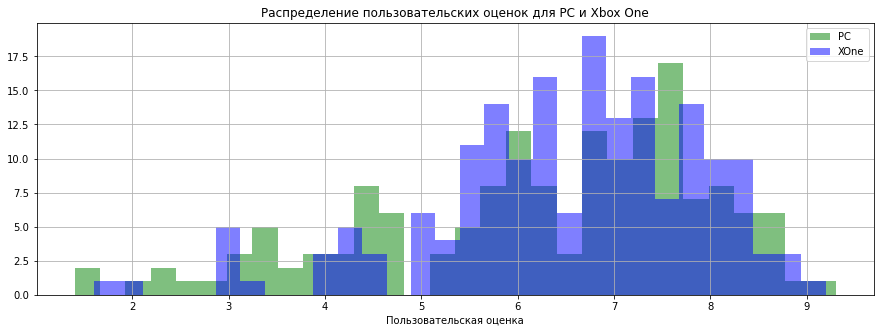

In [76]:
user_score_df[user_score_df.platform == 'PC'].user_score.hist(bins=30, alpha=0.5, color='green', figsize=(15,5))
user_score_df[user_score_df.platform == 'XOne'].user_score.hist(bins=30, alpha=0.5, color='blue', figsize=(15,5))
plt.title('Распределение пользовательских оценок для PC и Xbox One')
plt.xlabel('Пользовательская оценка')
plt.legend(['PC', 'XOne'])
plt.show()

In [77]:
display(user_score_df[user_score_df.platform == 'PC'].user_score.shape[0])
user_score_df[user_score_df.platform == 'XOne'].user_score.shape[0]

157

182

Оценки пользователей `PC` и `Xbox One` не зависят друг от друга, размеры выборок оценок достаточно велики (182 и 157 значений), поэтому согласно ЦПТ можно считать, что средние из этих выборок будут распределены нормально, также вид распределения самих значений похож на нормальный. Поэтому чтобы проверить равенство средних оценок пользователей `PC` и `Xbox One` можем провести t-тест для средних двух совокупностей с критическим уровнем статистической значимости в 5%. Т.к. размеры выборок отличаются, то параметр `equal_var` укажем как `False`.

In [78]:
results = st.ttest_ind(
    user_score_df[user_score_df.platform == 'XOne'].user_score,
    user_score_df[user_score_df.platform == 'PC'].user_score,
    equal_var=False
)

alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.13888973874685429
Не получилось отвергнуть нулевую гипотезу


Согласно нашей нулевой гипотезе, за актуальный период средняя оценка пользователей `Xbox One` равна средней оценке пользователей `PC`, мы получили значение p-value (0.139) больше заданного критического уровня статистической значимости alpha (0.05), что говорит о том, что нулевую гипотезу нельзя отвергнуть. Это справедливо и даже для более высокого значения уровня значимости в 10%. Таким образом, оставляем нулевую гипотезу - средние пользовательские рейтинги игр для платформ `Xbox One` и `PC` одинаковые.

**Проверка гипотезы: Средние пользовательские рейтинги жанров `Action` (англ. «действие», экшен-игры) и `Sports` (англ. «спортивные соревнования») разные.**

```
H_0: Оценка (user_score) пользователей игр жанра Action = оценка (user_score) пользователей игр жанра Sports
H_a: Оценка (user_score) пользователей игр жанра Action ≠ оценка (user_score) пользователей игр жанра Sports
alpha = 0.05
```

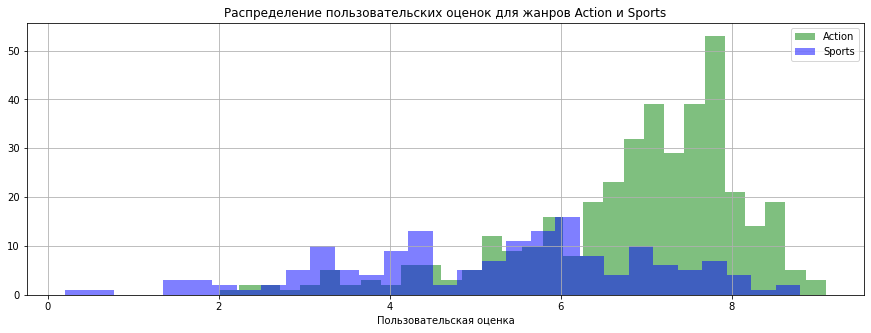

In [79]:
user_score_df[user_score_df.genre == 'Action'].user_score.hist(bins=30,alpha=0.5, color='green', figsize=(15,5))
user_score_df[user_score_df.genre == 'Sports'].user_score.hist(bins=30,alpha=0.5,color='blue', figsize=(15,5))
plt.title('Распределение пользовательских оценок для жанров Action и Sports')
plt.xlabel('Пользовательская оценка')
plt.legend(['Action', 'Sports'])
plt.show()

In [80]:
display(user_score_df[user_score_df.genre == 'Action'].user_score.shape[0])
user_score_df[user_score_df.genre == 'Sports'].user_score.shape[0]

391

160

Распределения пользовательских оценок игр жанров `Action` и `Sports` похожи на нормальные и т.к. выборки достаточно велики и независимы друг от друга, то можем использовать t-тест для сравнения средних двух совокупностей. Т.к. размеры выборок отличаются, то параметр `equal_var` укажем как `False`. Значение критического уровня статистической значимости `alpha` возьмем `5%`.

In [81]:
results = st.ttest_ind(
    user_score_df[user_score_df.genre == 'Action'].user_score,
    user_score_df[user_score_df.genre == 'Sports'].user_score,
    equal_var=False
)

alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1.6948835429264077e-20
Отвергаем нулевую гипотезу


Согласно нашей нулевой гипотезе средние пользовательские рейтинги жанров `Action` и `Sports` одинаковы. При полученном значении p-value в 1.69e-20 следует отвергнуть нулевую гипотезу, это будет справедливо и для уровня статистической значимости в 1%. Таким образом, отвергаем нулевую гипотезу и принимаем альтернативную - средние пользовательские рейтинги жанров `Action` и `Sports` различаются.

За актуальный период с 2013 года:
* Средние пользовательские оценки игроков на `Xbox One` и `PC` одинаковы. Это справедливо даже для критического уровня статистической значимости 10%.
* Средние пользовательские рейтинги игр жанров `Action` и `Sports` разные. Это справедливо для критического уровня статистической значимости 1%.

## Общий вывод

### Обработка данных

* Привели названия столбцов к единому виду в нижнем регистре
* Заполнили пропуски для года выпуска игр там, где это возможно
* Удалили строки с пропущенными значениями там, где это не повлияет на дальнейший анализ (всего удалено 0.95% строк)
* Подсчитали суммарные продажи игр во всех регионах

### Анализ данных

#### Выпуск игр в разные годы
Рост количества выпускаемых игр в год начался со второй половины 90-х годов и продолжился до 2008 года, далее наблюдается спад, однако это количество не падает ниже, чем по состоянию на 2000 год.
#### Продажи по платформам
* Больше всего с 1980 года было продано игр для платформ `Sony PlayStation 2`, `Microsoft Xbox 360`, `Sony PlayStation 3`, `Nintendo Wii` и `Nintendo DS`. Начиная от выхода консоли количество проданных игр растет в течение примерно пяти лет, далее это количество уменьшается с приближением к году выхода следующего поколения консоли. Одно поколение консоли остается актуальным в течение 7-10 лет, включая 2-3 года после выхода уже следующего поколения.
* Т.к. компьютеров нет как таковых поколений, то в продажах игр для них не наблюдается цикличный рост и продаж игр. Заметен рост как выпуска, таки продаж игр с 2000 до 2011 года и последующим спадом продаж. С 2013 года вновь наблюдается рост выпуска игры для `PC`.

#### Актуальный период и платформы
Актуальный период для дальнейшего анализа можно выбрать начиная с 2013 года. Это 3 последних года, также именно в этот год вышли наиболее популярные платформы на данный момент - `PlayStation 4` и `Xbox One`. Именно эти консоли и только они показывают рост количества проданных игр в этот период, если они будут соответствовать своим предыдущим поколениям, то этот рост должен продолжиться примерно до 2018 года. Таким образом это наиболее перспективные актуальные платформы. Также хорошие показатели у `Nintendo 3DS`, но на данный момент продажи игр для этой консоли уже падают. Неудачный старт получился у консоли `Nintendo Wii U` - уже через 2 года после выхода продажи стали снижаться. `PC` можно рассматривать как перспективную платформу, т.к. с учетом предыдущих лет скорее всего сильный спад продаж не будет наблюдаться, а по состоянию на 2016 год игры для компьютеров также продаются успешно.
#### Зависимость продаж от оценок критиков и пользователей
Ни для одной из платформ не наблюдается прямой зависимости количества проданных игр от пользовательской оценки или оценки критиков. Можно лишь сказать, что в целом при пользовательской оценке выше 6 и оценке критиков выше 70 количество проданных игр несколько больше.
#### Распределение игр по жанрам
Наибольшее количество игр, выпущенных с 2013 года - игры жанра `Action`. Также этот жанр является и самым прибыльным - продано больше всего копий игр. Однако это объясняется наличием одной сверхуспешной игры - `Grand Theft Auto V`, а многие другие игры этого жанра не так популярны. Стабильно успешны игры жанров `Shooter`, `Sports` и `Platform`.

### Портрет пользователя каждого региона
#### Самые популярные платформы (топ-5)
* В **Северной Америке** и **Европе** с 2013 года наиболее популярны одни и те же платформы - `PlayStation 3 и 4`, `Xbox 360 и One`, `Nintendo 3DS`. Лидирует в обоих регионах `PlayStation 4`.
* В **Европе** приставки от `Sony` - `PS3` и `PS4` заметно успешнее своих прямых конкурентов от `Microsoft` - `X360` и `XOne`.
* В **Северной Америке** `Xbox 360` опережает своего конкурента `PlayStation 3` по продажам игр, а `Xbox One` хоть и уступает `PlayStation 4`, но не так значительно как в **Европе**.
* Игровой рынок **Японии** сильно отличается от североамериканского и европейского. Лидирует по общему количеству проданных игр `Nintendo 3DS`, тогда как в других регионах она лишь пятая. Также в пятерку лучших входят `PlayStation Vita` и `Nintendo Wii U`, которых нет среди наиболее успешных в других регионах. Японские пользователи предпочитают консоли своего производства, приставок от `Microsoft` нет среди популярных в этой стране.

#### Самые популярные жанры (топ-5)
* В целом игровые рынки **Северной Америки** и **Европы** похожи. В этих регионах лидируют игры жанра `Shooter` и `Platform`, причем продажи жанра `Shooter` в два раза выше следующего за ним жанра `Platform`. Также во всех этих регионах популярен жанр `Sports`. В **Европе** среди лучших пристутсвует жанр `Simulation` (и только в Европе среди трех представленных регионов), а в **Северной Америке** жанр `Fighting`.
* **Японский** рынок вновь отличается. Наиболее популярный жанр игр в этой стране - `Role-Playing`, причем в остальных регионах этот жанр даже не присутствует в топ 5. Еще три жанра (`Misc`, `Puzzle` и `Action`), популярных в **Японии**, также не входят в пятерку лучших в **Северной Америке** и **Европе**, а лидирующие там жанры `Shooter`, `Platform` и `Sports` не входят в пятерку в **Японии**.

#### Рейтинг ESRB
* В **Северной Америке** и **Европе** значений также больше все продано игр с рейтингом `M` - в данном случае этот рейтинг соответствует играм жанра `Shooting`, наиболее стабильно популярного в этих регионах. Рейтинги `E10+` - `Everyone 10 and older` и `E` - `Everyone` присваиваются играм многих жанров, поэтому игры данных рейтингов также составляют большую долю продаж в этих регионах.
* В **Японии** большинство проданных игр не имеют рейтинга, это объясняется тем, что рейтинг ESRB предназначен для США и Канады. В **Европе** играют в те же игры, что и в **Северной Америке**, поэтому и рейтинги совпадают, а в **Японии** популярны другие жанры, для которых уже рейтинг ESRB не присвоен, т.к. эти игры вероятно выпускаются специально для японского рынка.

### Средние пользовательские оценки
За актуальный период с 2013 года:
* Средние пользовательские оценки игроков на `Xbox One` и `PC` одинаковы. Это справедливо даже для критического уровня статистической значимости 10%.
* Средние пользовательские рейтинги игр жанров `Action` и `Sports` разные. Это справедливо для критического уровня статистической значимости 1%.